### Importazione librerie

In [1]:
import pandas as pd
import numpy as np
import ccxt
from ta.volatility import AverageTrueRange, BollingerBands
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD
from ta.volume import OnBalanceVolumeIndicator
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import lightgbm as lgb
import warnings
import time
import matplotlib.pyplot as plt
import itertools
warnings.filterwarnings('ignore')

### Raccolta dati
Utilizziamo la funzione download_and_plot per scaricare i dati di Bitcoin da Bybit per il 2024 con timeframe di 1 minuto e li salviamo in un DataFrame.

In [2]:
def download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot):
    exchange_class = getattr(ccxt, market)
    exchange = exchange_class()
    exchange.load_markets()
    cryptos_pairs = [f"{crypto}/USDT" for crypto in cryptos]
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)
    data_frames = {}
    for pair in cryptos_pairs:
        if pair not in exchange.markets:
            raise ValueError(f"Il mercato {pair} non è disponibile su {market}.")
        print(f"Scarico i dati per {pair} dal {start_date} al {end_date}...")
        ohlcv = []
        since = start_timestamp
        while since < end_timestamp:
            batch = exchange.fetch_ohlcv(pair, timeframe_download, since)
            if not batch:
                break
            ohlcv.extend(batch)
            since = batch[-1][0] + 1
            time.sleep(exchange.rateLimit / 1000)
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        df = df[df.index <= pd.Timestamp(end_date)]
        data_frames[pair] = df
    return {k.replace('/USDT', ''): v for k, v in data_frames.items()}

In [3]:
# # Parametri per il download
# cryptos = ['BTC']
# market = 'bybit'
# timeframe_download = '1m'
# start_date = '2024-01-01'
# end_date = '2024-12-31'
# plot = False  # Imposta a True se vuoi visualizzare i grafici

# # Scarica i dati
# data = download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot)
# btc_df = data['BTC']

# # Visualizza le prime righe per controllo
# btc_df

btc_df = pd.read_csv('Bitcoin (USDT) 2024 timeframe 1m.csv')
btc_df.set_index('timestamp', inplace=True)
btc_df.index = pd.to_datetime(btc_df.index)
btc_df

,open,high,low,close,volume
timestamp,,,,,
2024-01-01 00:00:00,42284.00,42300.00,42260.01,42300.00,15.059749
2024-01-01 00:01:00,42300.00,42321.99,42299.99,42320.28,4.240722
2024-01-01 00:02:00,42320.28,42335.79,42317.30,42322.57,5.671511
2024-01-01 00:03:00,42322.57,42370.00,42322.57,42366.50,6.801620
2024-01-01 00:04:00,42366.50,42399.68,42366.50,42399.68,6.264730
...,...,...,...,...,...
2024-12-30 23:56:00,92816.59,92878.51,92789.85,92870.74,6.900125
2024-12-30 23:57:00,92870.74,92895.11,92838.44,92844.67,6.369311
2024-12-30 23:58:00,92844.67,92845.68,92797.10,92831.16,6.396956


### Feature engineering
Calcoliamo le feature richieste: ATR, RSI, medie mobili semplici (SMA) ed esponenziali (EMA), deviazioni standard mobili, minimi e massimi mobili, sia sui prezzi che sulle variazioni percentuali. Aggiungiamo anche le derivate prima, seconda e terza.

In [4]:
def calculate_indicators_2(df, windows, atr_windows, rsi_windows, macd_windows=[12, 26, 9], bb_windows=[20], stoch_windows=[14], lag_windows=[1, 2, 5, 10]):
    price_types = ['open', 'high', 'low', 'close']

    # Calcolo della variazione percentuale
    for price_type in price_types:
        df[f'pct_change_{price_type}'] = df[price_type].pct_change()

    # ATR
    for atr_window in atr_windows:
        df[f'ATR_{atr_window}'] = AverageTrueRange(df['high'], df['low'], df['close'], window=atr_window).average_true_range()

    # RSI
    for price_type in price_types:
        for rsi_window in rsi_windows:
            df[f'RSI_{price_type}_{rsi_window}'] = RSIIndicator(df[price_type], window=rsi_window).rsi()

    # MACD
    for price_type in price_types:
        macd = MACD(df[price_type], window_slow=macd_windows[1], window_fast=macd_windows[0], window_sign=macd_windows[2])
        df[f'MACD_{price_type}'] = macd.macd()
        df[f'MACD_signal_{price_type}'] = macd.macd_signal()
        df[f'MACD_diff_{price_type}'] = macd.macd_diff()

    # Bollinger Bands
    for price_type in price_types:
        for bb_window in bb_windows:
            bb = BollingerBands(df[price_type], window=bb_window, window_dev=2)
            df[f'BB_high_{price_type}_{bb_window}'] = bb.bollinger_hband()
            df[f'BB_low_{price_type}_{bb_window}'] = bb.bollinger_lband()
            df[f'BB_mid_{price_type}_{bb_window}'] = bb.bollinger_mavg()

    # Stochastic Oscillator
    for stoch_window in stoch_windows:
        stoch = StochasticOscillator(df['high'], df['low'], df['close'], window=stoch_window)
        df[f'Stoch_k_{stoch_window}'] = stoch.stoch()
        df[f'Stoch_d_{stoch_window}'] = stoch.stoch_signal()

    # On-Balance Volume
    df['OBV'] = OnBalanceVolumeIndicator(df['close'], df['volume']).on_balance_volume()

    # Feature temporali
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek

    # Lag features per i prezzi e variazioni percentuali
    for lag in lag_windows:
        for price_type in price_types:
            df[f'{price_type}_lag_{lag}'] = df[price_type].shift(lag)
            df[f'pct_change_{price_type}_lag_{lag}'] = df[f'pct_change_{price_type}'].shift(lag)

    # SMA, EMA, STD, MIN, MAX
    for window in windows:
        for price_type in price_types:
            df[f'SMA_{price_type}_{window}'] = df[price_type].rolling(window=window).mean()
            df[f'EMA_{price_type}_{window}'] = df[price_type].ewm(span=window, adjust=False).mean()
            df[f'STD_{price_type}_{window}'] = df[price_type].rolling(window=window).std()
            df[f'MIN_{price_type}_{window}'] = df[price_type].rolling(window=window).min()
            df[f'MAX_{price_type}_{window}'] = df[price_type].rolling(window=window).max()

            # Indicatori sulle variazioni percentuali
            df[f'SMA_PCT_{price_type}_{window}'] = df[f'pct_change_{price_type}'].rolling(window=window).mean()
            df[f'EMA_PCT_{price_type}_{window}'] = df[f'pct_change_{price_type}'].ewm(span=window, adjust=False).mean()
            df[f'STD_PCT_{price_type}_{window}'] = df[f'pct_change_{price_type}'].rolling(window=window).std()
            df[f'MIN_PCT_{price_type}_{window}'] = df[f'pct_change_{price_type}'].rolling(window=window).min()
            df[f'MAX_PCT_{price_type}_{window}'] = df[f'pct_change_{price_type}'].rolling(window=window).max()

    # Calcolo delle derivate
    feature_cols = [col for col in df.columns if col not in ['hour', 'day_of_week']]
    for col in feature_cols:
        df[f'{col}_diff1'] = df[col].diff()
        df[f'{col}_diff2'] = df[col].diff().diff()
        df[f'{col}_diff3'] = df[col].diff().diff().diff()

    return df

In [5]:
windows = [20, 50, 200]
atr_windows = [5, 14, 60]
rsi_windows = [5, 14, 60]
macd_windows = [12, 26, 9]  # Fast, Slow, Signal
bb_windows = [20]
stoch_windows = [14]
lag_windows = [1, 2, 5, 10]
btc_df = calculate_indicators_2(btc_df, windows, atr_windows, rsi_windows, macd_windows, bb_windows, stoch_windows, lag_windows)
btc_df = btc_df.dropna()
btc_df

,open,high,low,close,volume,pct_change_open,pct_change_high,pct_change_low,pct_change_close,ATR_5,...,EMA_PCT_close_200_diff3,STD_PCT_close_200_diff1,STD_PCT_close_200_diff2,STD_PCT_close_200_diff3,MIN_PCT_close_200_diff1,MIN_PCT_close_200_diff2,MIN_PCT_close_200_diff3,MAX_PCT_close_200_diff1,MAX_PCT_close_200_diff2,MAX_PCT_close_200_diff3
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-01 03:23:00,42461.01,42461.01,42442.86,42442.86,2.123256,-0.000447,-0.000669,-0.000427,-0.000427,17.596708,...,0.000008,-5.380293e-06,-6.720369e-06,-8.910441e-06,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-01 03:24:00,42442.86,42450.69,42442.86,42446.00,1.465701,-0.000427,-0.000243,0.000000,0.000074,15.643366,...,0.000005,-3.793190e-06,1.587102e-06,8.307471e-06,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-01 03:25:00,42446.00,42456.80,42446.00,42453.05,0.247349,0.000074,0.000144,0.000074,0.000166,14.674693,...,-0.000004,-1.337472e-07,3.659443e-06,2.072341e-06,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-01 03:26:00,42453.05,42454.17,42439.13,42439.13,3.225596,0.000166,-0.000062,-0.000162,-0.000328,14.747754,...,-0.000006,-1.253501e-07,8.397144e-09,-3.651046e-06,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-01 03:27:00,42439.13,42444.00,42437.75,42442.14,11.095998,-0.000328,-0.000240,-0.000033,0.000071,13.048203,...,0.000009,-3.841145e-07,-2.587645e-07,-2.671616e-07,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 23:56:00,92816.59,92878.51,92789.85,92870.74,6.900125,0.000446,0.000181,0.000157,0.000583,65.775346,...,-0.000004,8.358915e-07,1.291975e-06,1.401959e-06,0.0,0.0,0.0,0.0,0.0,0.0
2024-12-30 23:57:00,92870.74,92895.11,92838.44,92844.67,6.369311,0.000583,0.000179,0.000524,-0.000281,63.954277,...,-0.000010,-2.233993e-06,-3.069885e-06,-4.361860e-06,0.0,0.0,0.0,0.0,0.0,0.0
2024-12-30 23:58:00,92844.67,92845.68,92797.10,92831.16,6.396956,-0.000281,-0.000532,-0.000445,-0.000146,60.879421,...,0.000010,-1.040317e-06,1.193676e-06,4.263561e-06,0.0,0.0,0.0,0.0,0.0,0.0


### Preparazione dei dati
Raggruppiamo i dati per giorno, li mischiamo casualmente e li dividiamo in train, validation e test sets.

In [6]:
def prepare_data(df, F, train_size=0.7, val_size=0.2, seed=42):
    """
    Prepara i dati per il training dividendo casualmente in train, validation e test set.
    
    Args:
        df (pd.DataFrame): DataFrame contenente i dati con feature e colonna 'close'.
        F (int): Numero di minuti nel futuro per il target.
        train_size (float): Percentuale di dati per il training (default: 0.7).
        val_size (float): Percentuale di dati per la validation (default: 0.2).
        seed (int): Seme per la riproducibilità (default: 42).
    
    Returns:
        X_train, y_train, X_val, y_val, X_test, y_test: Suddivisioni dei dati.
    """
    test_size = 1 - train_size - val_size  # Calcola la percentuale per il test set
    
    # Target: variazione del prezzo dopo F candele
    y = df['close'].shift(-F) - df['close']  # Variazione del prezzo come target
    
    # Rimuovi le ultime F righe dove y è NaN
    X = df.iloc[:-F]  # Feature
    y = y.iloc[:-F]   # Target
    
    # Prima suddivisione: separa train+val da test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=seed, 
        shuffle=True
    )
    
    # Calcola la proporzione per train e val rispetto al set rimanente (train+val)
    train_proportion = train_size / (train_size + val_size)
    
    # Seconda suddivisione: separa train da validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, 
        train_size=train_proportion, 
        random_state=seed, 
        shuffle=True
    )
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [7]:
# Parametri regolabili
F = 60  # Numero di candele avanti da prevedere
train_size = 0.7  # 70% dei giorni rimanenti per il train
val_size = 0.2  # 20% dei giorni rimanenti per la validation
seed = 8

# Prepara i dati (assumendo che btc_df sia il DataFrame con i dati)
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(btc_df, F, train_size, val_size, seed)

# Controllo delle dimensioni
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (367736, 814), Validation: (105068, 814), Test: (52534, 814)


### Costruzione e addestramento dei modelli
Costruiamo e addestriamo un modello Random Forest e una rete neurale

#### Random forest

In [ ]:
def train_random_forest_2(X_train, y_train, X_val, y_val, X_test, y_test):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 5],
        'max_features': ['sqrt', 'log2']
    }
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=4, verbose=2)
    grid_search.fit(X_train, y_train)
    best_rf = grid_search.best_estimator_
    
    # Predizioni e metriche
    rf_pred = best_rf.predict(X_test)
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
    rf_mae = mean_absolute_error(y_test, rf_pred)
    rf_mape = mean_absolute_percentage_error(y_test, rf_pred)
    rf_direction_accuracy = np.mean(np.sign(rf_pred) == np.sign(y_test))
    
    print(f"Best Random Forest Params: {grid_search.best_params_}")
    print(f"Random Forest - RMSE: {rf_rmse:.4f}, MAE: {rf_mae:.4f}, MAPE: {rf_mape:.4f}")
    print(f"Random Forest Directional Accuracy: {rf_direction_accuracy:.4f}")
    
    # Feature importances
    importances = best_rf.feature_importances_
    importances_pct = 100.0 * (importances / importances.sum())
    feats_imp = pd.DataFrame({
        'feature': X_train.columns,
        'importance_pct': importances_pct
    }).sort_values('importance_pct', ascending=True)
    
    print("\nFeature Importances (valore percentuale):")
    print(feats_imp.sort_values('importance_pct', ascending=False))
    
    plt.figure(figsize=(8, 4))
    plt.barh(feats_imp['feature'], feats_imp['importance_pct'], color='skyblue')
    plt.xlabel('Feature Importance (%)')
    plt.title('Random Forest Feature Importances')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
    
    return best_rf, rf_pred, rf_rmse, rf_mae, rf_mape, rf_direction_accuracy

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=50; total time= 4.1min
[CV] END max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=50; total time= 3.5min
[CV] END max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=50; total time= 3.5min
[CV] END max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=100; total time= 6.8min
[CV] END max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=100; total time= 7.7min
[CV] END max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=100; total time= 7.3min
[CV] END max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=13.1min
[CV] END max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=13.1min
[CV] END max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=13.3min
[CV] END max_depth=5, max_features=sqrt, min_sampl

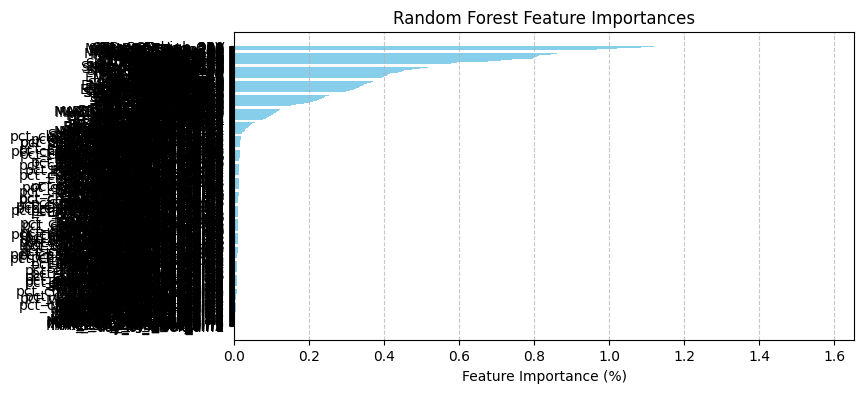

In [18]:
rf_model, rf_pred, rf_rmse, rf_mae, rf_mape, rf_direction_accuracy = train_random_forest_2(X_train, y_train, X_val, y_val, X_test, y_test)

#### Rete neurale

In [19]:
def train_neural_network_regressor_2(
    X_train, y_train, X_val, y_val, X_test, y_test,
    network_width=1024, network_depth=3, activation_function='relu',
    patience=5, epochs=10000, batch_size=32, monitor='val_loss', loss='mse'
):
    X_train_np = X_train.values
    y_train_np = y_train.values
    X_val_np = X_val.values
    y_val_np = y_val.values
    X_test_np = X_test.values
    y_test_np = y_test.values

    model = Sequential()
    model.add(InputLayer(input_shape=(X_train_np.shape[1],)))
    for _ in range(network_depth):
        model.add(Dense(network_width, activation=activation_function))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss=loss, metrics=['mae', 'mape'])
    early_stop = EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=True)

    history = model.fit(
        X_train_np, y_train_np,
        validation_data=(X_val_np, y_val_np),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    nn_pred = model.predict(X_test_np).flatten()
    nn_rmse = np.sqrt(mean_squared_error(y_test_np, nn_pred))
    nn_mae = mean_absolute_error(y_test_np, nn_pred)
    nn_mape = mean_absolute_percentage_error(y_test_np, nn_pred)
    nn_direction_accuracy = np.mean(np.sign(nn_pred) == np.sign(y_test_np))

    print(f"Neural Network - RMSE: {nn_rmse:.4f}, MAE: {nn_mae:.4f}, MAPE: {nn_mape:.4f}")
    print(f"Neural Network Directional Accuracy: {nn_direction_accuracy:.4f}")

    epochs_range = range(1, len(history.history['loss']) + 1)
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history.history['loss'], label='Train Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Loss durante l’Addestramento')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history.history['mae'], label='Train MAE')
    plt.plot(epochs_range, history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('MAE durante l’Addestramento')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history.history['mape'], label='Train MAPE')
    plt.plot(epochs_range, history.history['val_mape'], label='Validation MAPE')
    plt.xlabel('Epoch')
    plt.ylabel('MAPE')
    plt.title('MAPE durante l’Addestramento')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model, history, nn_pred, nn_rmse, nn_mae, nn_mape, nn_direction_accuracy

Epoch 1/10000
11492/11492 ━━━━━━━━━━━━━━━━━━━━ 423s 36ms/step - loss: 35257384.0000 - mae: 600.0906 - mape: 16871616.0000 - val_loss: 142933.6094 - val_mae: 239.4265 - val_mape: 259696.0156
Epoch 2/10000
11492/11492 ━━━━━━━━━━━━━━━━━━━━ 419s 36ms/step - loss: 278098.1875 - mae: 251.4328 - mape: 845909.7500 - val_loss: 142929.8125 - val_mae: 239.4211 - val_mape: 318053.0625
Epoch 3/10000
11492/11492 ━━━━━━━━━━━━━━━━━━━━ 396s 34ms/step - loss: 142099.6719 - mae: 240.1930 - mape: 437576.3438 - val_loss: 142917.3125 - val_mae: 239.4077 - val_mape: 616274.3750
Epoch 4/10000
11492/11492 ━━━━━━━━━━━━━━━━━━━━ 388s 34ms/step - loss: 143925.6406 - mae: 240.6674 - mape: 772894.6875 - val_loss: 142916.2188 - val_mae: 239.4169 - val_mape: 895005.5625
Epoch 5/10000
11492/11492 ━━━━━━━━━━━━━━━━━━━━ 383s 33ms/step - loss: 143394.5156 - mae: 240.5810 - mape: 779848.0000 - val_loss: 142918.3125 - val_mae: 239.4094 - val_mape: 574230.5000
Epoch 6/10000
11492/11492 ━━━━━━━━━━━━━━━━━━━━ 387s 34ms/step - lo

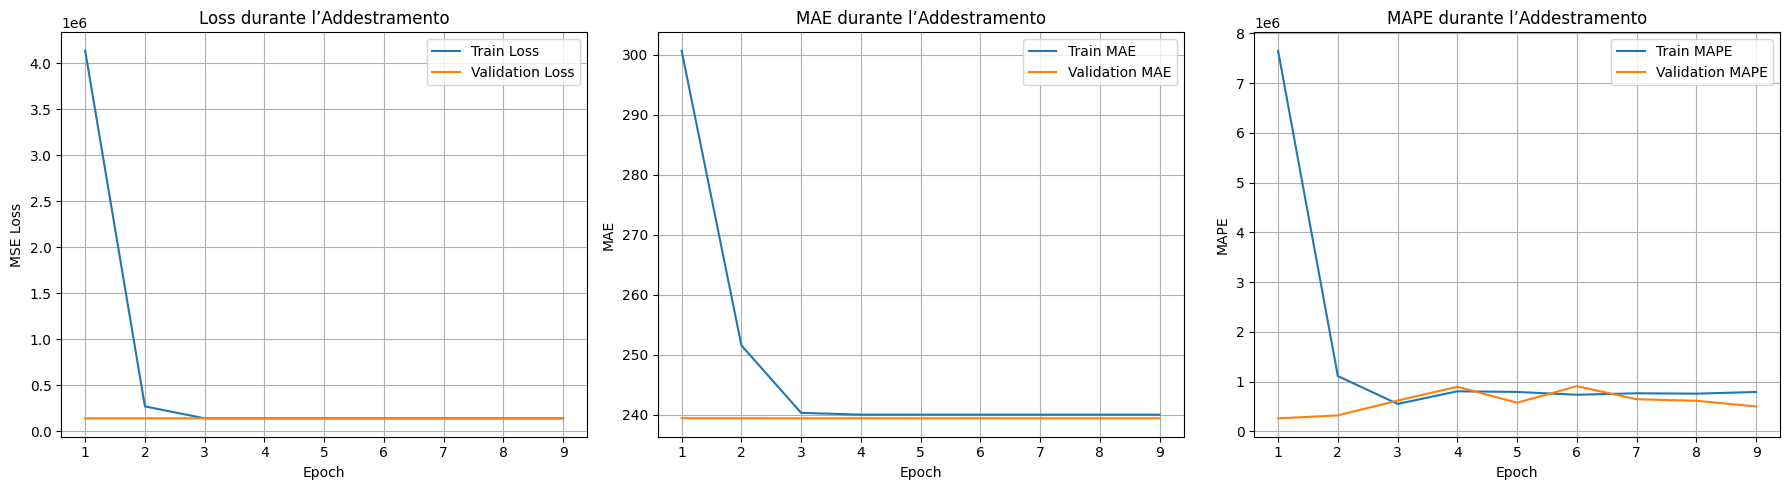

In [20]:
nn_model, nn_history, nn_pred, nn_rmse, nn_mae, nn_mape, nn_direction_accuracy = train_neural_network_regressor_2(
    X_train, y_train, X_val, y_val, X_test, y_test
)

#### LSTM

In [8]:
def create_sequences(X, y, lookback, forecast_horizon=1):
    X_seq, y_seq = [], []
    for i in range(lookback, len(X) - forecast_horizon):
        X_seq.append(X.iloc[i - lookback:i].values)
        y_seq.append(y.iloc[i + forecast_horizon])
    return np.array(X_seq), np.array(y_seq)

In [9]:
def train_lstm_model_2(
    X_train, y_train, X_val, y_val, X_test, y_test,
    lookback=60, forecast_horizon=F, lstm_units=50, num_layers=1,
    dropout_rate=0.2, dense_units=10, use_bidirectional=False,
    activation='tanh', recurrent_activation='sigmoid',
    epochs=100, batch_size=32, learning_rate=0.001, patience=10,
    optimizer='adam', loss_function='mse'
):
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, lookback, forecast_horizon)
    X_val_seq, y_val_seq = create_sequences(X_val, y_val, lookback, forecast_horizon)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, lookback, forecast_horizon)
    
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            if use_bidirectional:
                model.add(Bidirectional(LSTM(
                    units=lstm_units,
                    activation=activation,
                    recurrent_activation=recurrent_activation,
                    return_sequences=(num_layers > 1),
                    input_shape=(lookback, X_train.shape[1])
                )))
            else:
                model.add(LSTM(
                    units=lstm_units,
                    activation=activation,
                    recurrent_activation=recurrent_activation,
                    return_sequences=(num_layers > 1),
                    input_shape=(lookback, X_train.shape[1])
                ))
        else:
            if use_bidirectional:
                model.add(Bidirectional(LSTM(
                    units=lstm_units,
                    activation=activation,
                    recurrent_activation=recurrent_activation,
                    return_sequences=(i < num_layers - 1)
                )))
            else:
                model.add(LSTM(
                    units=lstm_units,
                    activation=activation,
                    recurrent_activation=recurrent_activation,
                    return_sequences=(i < num_layers - 1)
                ))
    
    model.add(Dropout(dropout_rate))
    if dense_units > 0:
        model.add(Dense(units=dense_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    opt = Adam(learning_rate=learning_rate) if optimizer.lower() == 'adam' else optimizer
    model.compile(optimizer=opt, loss=loss_function)

    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=2
    )

    lstm_pred = model.predict(X_test_seq).flatten()
    lstm_rmse = np.sqrt(mean_squared_error(y_test_seq, lstm_pred))
    lstm_mae = mean_absolute_error(y_test_seq, lstm_pred)
    lstm_mape = mean_absolute_percentage_error(y_test_seq, lstm_pred)
    lstm_direction_accuracy = np.mean(np.sign(lstm_pred) == np.sign(y_test_seq))

    print(f"LSTM - RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}, MAPE: {lstm_mape:.4f}")
    print(f"LSTM Directional Accuracy: {lstm_direction_accuracy:.4f}")

    return model, history, lstm_pred, y_test_seq, lstm_rmse, lstm_mae, lstm_mape, lstm_direction_accuracy

In [ ]:
lstm_model, lstm_history, lstm_pred, y_test_seq, lstm_rmse, lstm_mae, lstm_mape, lstm_direction_accuracy = train_lstm_model_2(
    X_train, y_train, X_val, y_val, X_test, y_test
)

#### LGBM

In [ ]:
# def train_lightgbm_2(X_train, y_train, X_val, y_val, X_test, y_test):
#     train_data = lgb.Dataset(X_train, label=y_train)
#     val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
#     params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'boosting_type': 'gbdt',
#         'num_leaves': 31,
#         'learning_rate': 0.05,
#         'feature_fraction': 0.9
#     }
#     lgb_model = lgb.train(
#         params,
#         train_data,
#         num_boost_round=10000,
#         valid_sets=[val_data],
#         callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(10)]
#     )
#     lgb_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
#     lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
#     lgb_mae = mean_absolute_error(y_test, lgb_pred)
#     lgb_mape = mean_absolute_percentage_error(y_test, lgb_pred)
#     lgb_direction_accuracy = np.mean(np.sign(lgb_pred) == np.sign(y_test))

#     print(f"LightGBM - RMSE: {lgb_rmse:.4f}, MAE: {lgb_mae:.4f}, MAPE: {lgb_mape:.4f}")
#     print(f"LightGBM Directional Accuracy: {lgb_direction_accuracy:.4f}")

#     return lgb_model, lgb_pred, lgb_rmse, lgb_mae, lgb_mape, lgb_direction_accuracy

# Early stopping, best iteration is:
# [3879]	valid_0's rmse: 142.769
# LightGBM - RMSE: 143.7226, MAE: 102.0752, MAPE: 7238066441762.0635
# LightGBM Directional Accuracy: 0.8677

In [ ]:
def train_lightgbm_optimized(X_train, y_train, X_val, y_val, X_test, y_test, param_grid):
    best_model = None
    best_rmse = float('inf')
    best_idx = None
    best_combination = None

    # Calcola il numero totale di combinazioni
    total_combinations = len(list(itertools.product(*param_grid.values())))

    # Genera tutte le combinazioni di parametri
    keys, values = zip(*param_grid.items())
    for idx, combination in enumerate(itertools.product(*values), 1):
        params = dict(zip(keys, combination))

        # Estrai num_boost_round e stopping_rounds dalla griglia
        num_boost_round = params.pop('num_boost_round')
        stopping_rounds = params.pop('stopping_rounds')

        # Aggiungi parametri fissi
        params['objective'] = 'regression'
        params['metric'] = 'rmse'
        params['boosting_type'] = 'gbdt'

        # Stampa la combinazione che sta per essere testata
        print(f"\nTesting combination {idx}/{total_combinations}:\n{params}\nnum_boost_round={num_boost_round}\nstopping_rounds={stopping_rounds}")

        # Crea i dataset per LightGBM
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

        # Addestra il modello con early stopping
        model = lgb.train(
            params,
            train_data,
            num_boost_round=num_boost_round,
            valid_sets=[val_data],
            callbacks=[lgb.early_stopping(stopping_rounds=stopping_rounds), lgb.log_evaluation(10)]
        )

        # Calcola RMSE e accuratezza direzionale sul validation set
        val_pred = model.predict(X_val, num_iteration=model.best_iteration)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        val_directional_accuracy = np.mean(np.sign(val_pred) == np.sign(y_val))

        # Stampa i risultati della combinazione appena testata
        print(f"Combination {idx}/{total_combinations} ({combination}) - Validation RMSE: {val_rmse:.4f}, Directional Accuracy: {val_directional_accuracy:.4f}")

        # Salva il modello migliore
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_model = model
            best_idx = idx

            best_combination = params.copy()
            best_combination['num_boost_round'] = num_boost_round
            best_combination['stopping_rounds'] = stopping_rounds
        
        print(f'Current best rmse: {best_rmse}, with idx {best_idx} and parameters {best_combination}')

    # Predizioni sui vari set con il modello migliore
    train_pred = best_model.predict(X_train, num_iteration=best_model.best_iteration)
    val_pred = best_model.predict(X_val, num_iteration=best_model.best_iteration)
    test_pred = best_model.predict(X_test, num_iteration=best_model.best_iteration)

    # Stampa metriche finali per il miglior modello
    print("\nBest Model Results:")
    for dataset, y_true, pred in zip(['Train', 'Validation', 'Test'], 
                                     [y_train, y_val, y_test], 
                                     [train_pred, val_pred, test_pred]):
        rmse = np.sqrt(mean_squared_error(y_true, pred))
        directional_accuracy = np.mean(np.sign(pred) == np.sign(y_true))
        print(f"{dataset} - RMSE: {rmse:.4f}, Directional Accuracy: {directional_accuracy:.4f}")

    # Feature importances
    importances = best_model.feature_importance(importance_type='gain')
    importances_pct = 100.0 * (importances / importances.sum())
    feats_imp = pd.DataFrame({
        'feature': X_train.columns,
        'importance_pct': importances_pct
    }).sort_values('importance_pct', ascending=True)

    # Stampa il DataFrame con le feature importance
    print("\nFeature Importances (valore percentuale):")
    display(feats_imp.sort_values('importance_pct', ascending=False))

    # Grafico a barre orizzontali
    plt.figure(figsize=(8, 4))
    plt.barh(feats_imp['feature'], feats_imp['importance_pct'], color='skyblue')
    plt.xlabel('Feature Importance (%)')
    plt.title('LightGBM Feature Importances')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

    return best_model, test_pred, best_rmse


Testing combination 1/36:
{'num_leaves': 15, 'learning_rate': 0.05, 'max_depth': 5, 'feature_fraction': 0.7, 'random_state': 42, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt'}
num_boost_round=10000
stopping_rounds=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.885007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 207091
[LightGBM] [Info] Number of data points in the train set: 367736, number of used features: 814
[LightGBM] [Info] Start training from score 5.628216
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 373.807
[20]	valid_0's rmse: 371.138
[30]	valid_0's rmse: 368.646
[40]	valid_0's rmse: 366.138
[50]	valid_0's rmse: 364.034
[60]	valid_0's rmse: 362.32
[70]	valid_0's rmse: 360.714
[80]	valid_0's rmse: 358.659
[90]	valid_0's rmse: 356.888
[100]	valid_0's rmse: 354.893
[110]	valid_0's rmse: 353.383
[120]	valid_0's rmse: 351.475
[1

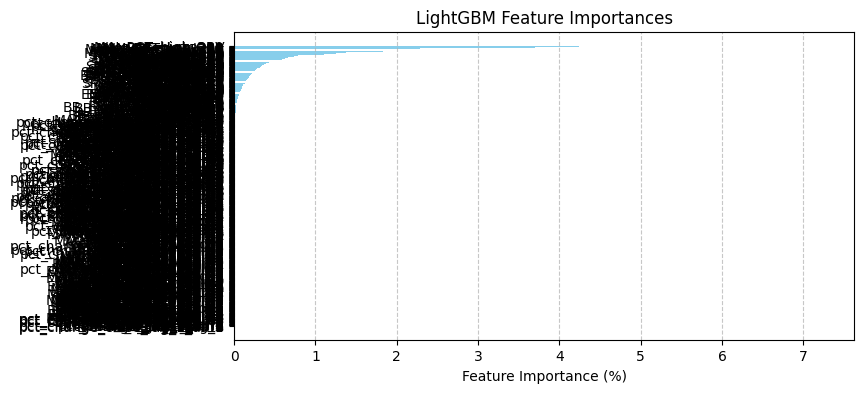

In [11]:
# La tua param_grid
param_grid = {
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 10, 20], # Provare anche None
    'feature_fraction': [0.7, 0.9],
    'random_state': [42],
    'num_boost_round': [10000], # Numero di alberi che vengono addestrati al massimo (a meno che non si fermi prima a causa di stopping_rounds)
    'stopping_rounds': [10]
}

# Esegui il modello
best_model, test_pred, best_rmse = train_lightgbm_optimized(X_train, y_train, X_val, y_val, X_test, y_test, param_grid)